In [1]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
from app.models import *
import joblib
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
import concurrent.futures

warnings.filterwarnings('ignore')

In [2]:
new_model = joblib.load("saved_models/MODEL.pkl")

model = new_model.best_estimator_
print(type(model))

<class 'sklearn.linear_model._logistic.LogisticRegression'>


In [3]:
import os
import datetime

def create_ranking_folder(season):
    """Создает новую папку для сохранения результатов ранжирования."""
    #current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    folder_name = f"data/ranking_seasons/rank_for_{season}"
    
    # Создаем папку, если её нет
    os.makedirs(folder_name, exist_ok=True)
    
    return folder_name

def rank_teams(season, matches, list_team, model_file, num_divisions, min_teams_per_division=3, num_generations=100, population_size=300):
    model = model_file  # Используем загруженную модель

    unique_teams = list_team['ID team'].unique()
    num_teams = len(unique_teams)
    
    if num_teams < num_divisions * min_teams_per_division:
        raise ValueError("Недостаточно команд для распределения по заданному количеству дивизионов")
    
    # Генерация всех возможных матчей
    all_matches = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_match = {
            executor.submit(get_team_win_probability, model, matches, team1, team2): (team1, team2)
            for team1 in unique_teams for team2 in unique_teams if team1 != team2
        }
        for future in tqdm(concurrent.futures.as_completed(future_to_match), total=len(future_to_match), desc="Генерация матчей"):
            team1, team2 = future_to_match[future]
            win_prob1 = future.result()
            win_prob2 = get_team_win_probability(model, matches, team2, team1)
            probabilities = normalize_probabilities([win_prob1, win_prob2])
            all_matches.append([team1, team2, probabilities[0] * 100, probabilities[1] * 100])
    
    matches_df = pd.DataFrame(all_matches, columns=['ID team', 'ID opponent', '%T', '%O'])
    
    # Генетический алгоритм
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(num_teams), num_teams)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    def evaluate(individual):
        divisions = [individual[i::num_divisions] for i in range(num_divisions)]
        if any(len(div) < min_teams_per_division for div in divisions):
            return float('inf'),
        if len(individual) != len(set(individual)):
            return float('inf'),
        
        score = 0
        for div in divisions:
            div_teams = unique_teams[div]
            div_matches = matches_df[(matches_df['ID team'].isin(div_teams)) & (matches_df['ID opponent'].isin(div_teams))]
            max_probs = div_matches[['%T', '%O']].max(axis=1)
            score += max_probs.mean()
        return score / num_divisions,
    
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)
    
    population = toolbox.population(n=population_size)
    pbar = tqdm(total=num_generations, desc="Эволюция")
    
    def eval_with_progress(individual):
        result = evaluate(individual)
        pbar.update(1)
        return result
    
    toolbox.register("evaluate", eval_with_progress)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)
    pbar.close()
    
    best_ind = tools.selBest(population, 1)[0]
    divisions = [best_ind[i::num_divisions] for i in range(num_divisions)]
    final_divisions = [[unique_teams[idx], f'Division {i+1}'] for i, div in enumerate(divisions) for idx in div]
    final_df = pd.DataFrame(final_divisions, columns=['ID team', 'division'])
    
    # Сохраняем файлы в новую папку
    matches_df.to_csv(f'data/ranking_seasons/rank_for_{season}/matches_rangirov.csv', index=False)
    final_df.to_csv(f'data/ranking_seasons/rank_for_{season}/team_rangirov_for_{season}.csv', index=False)
    print(f"Количество уникальных команд: {len(final_df)}")

def evaluate_league_distribution(season, new_model):
    game_before_season, unique_teams = process_season_data(season)

    if game_before_season is None or unique_teams is None:
        raise ValueError("Ошибка: `process_season_data` вернул None.")

    game_before_season.fillna(0, inplace=True)
    game_before_season.replace([np.inf, -np.inf], 0, inplace=True)

    matches = scale_and_select_features(game_before_season)
    
    if "result" in matches.columns:
        matches["result"] = matches["result"].map({'W': 1, 'L': -1, 'D': 0})
        matches.dropna(inplace=True)
    else:
        raise ValueError("Ошибка: Колонка 'result' отсутствует в данных.")

    division_teams = unique_teams.groupby('division')['ID team'].apply(list).to_dict()
    
    match_results_df = simulate_all_matches(new_model, division_teams, matches)

    average_highest_probabilities = calculate_average_highest_probabilities(match_results_df)
    
    match_results_df.to_csv('data/interim/simulated_matches.csv', index=False)

    for division, teams in division_teams.items():
        num_teams = len(teams)
        num_matches = num_teams * (num_teams - 1) // 2
        print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

    print("Среднее значение наибольших вероятностей для каждого дивизиона:")
    print(average_highest_probabilities)

    named_team_id('llhn', unique_teams, season)
    
    return matches, unique_teams, average_highest_probabilities

def named_team_id(name, unique_df_id, season):
    df_team_name = pd.read_csv("data/raw/teams_name_utf8.csv")
    
    filtered_name_df = df_team_name[df_team_name["ID team"].isin(unique_df_id["ID team"])]
    
    merged_df = pd.merge(unique_df_id, filtered_name_df, on='ID team', how='left')
    
    merged_df = merged_df.sort_values(by="division", ascending=True)
    
    desired_order = ["ID team", "TEAM_NAME", "division"]
    remaining_columns = [col for col in merged_df.columns if col not in desired_order]
    merged_df = merged_df[desired_order + remaining_columns]

    merged_df = add_ratings_to_ranking(season, merged_df)

    #merged_df.to_csv(f"data/ranking_seasons/rank_for_{season}/ranking_teams_{name}_{season}.csv", index=False)
    merged_df.to_excel(f"data/ranking_seasons/rank_for_{season}/ranking_teams_{name}_{season}.xlsx", index=False)

def rank_and_evaluate_teams(season, new_model, num_divisions=4, min_teams_per_division=5):
    ranking_folder = create_ranking_folder(season)  # Создаем папку для сохранения
    matches, unique_teams, old_probs = evaluate_league_distribution(season, new_model)

    # Пересчет рангов
    rank_teams(season, matches, unique_teams, new_model, num_divisions, min_teams_per_division)
    
    team_rangirov = pd.read_csv(f'data/ranking_seasons/rank_for_{season}/team_rangirov_for_{season}.csv')
    division_teams = team_rangirov.groupby('division')['ID team'].apply(list).to_dict()

    match_results_df = simulate_all_matches(new_model, division_teams, matches)
    new_probs = calculate_average_highest_probabilities(match_results_df)

    match_results_df.to_csv('data/interim/simulated_matches.csv', index=False)

    for division, teams in division_teams.items():
        num_teams = len(teams)
        num_matches = num_teams * (num_teams - 1) // 2
        print(f"Дивизион: {division}, Количество команд: {num_teams}, Количество матчей: {num_matches}")

    print("Среднее значение наибольших вероятностей для каждого дивизиона (новая модель):")
    print(new_probs)

    named_team_id('model', team_rangirov, season)

    visualize_division_distribution(old_probs, new_probs, season)

def visualize_division_distribution(original_probs, new_probs, season):
    """
    Визуализация сравнения вероятностей побед в дивизионах до и после перераспределения.
    
    :param original_probs: dict | np.ndarray — Исходные вероятности.
    :param new_probs: dict | np.ndarray — Вероятности после перераспределения.
    """

    if isinstance(original_probs, np.ndarray):
        divisions = np.arange(len(original_probs))
        original_probs = original_probs.tolist()
    else:
        divisions = sorted(original_probs.keys())
        original_probs = [original_probs[div] for div in divisions]

    if isinstance(new_probs, np.ndarray):
        new_probs = new_probs.tolist()
    else:
        new_probs = [new_probs.get(div, 0) for div in divisions]

    width = 0.4 
    x = np.arange(len(divisions))

    plt.figure(figsize=(10, 5))
    bars1 = plt.bar(x - width / 2, original_probs, width, color='blue', label='Initial distribution')
    bars2 = plt.bar(x + width / 2, new_probs, width, color='red', label='Distribution by model')

    plt.xlabel("Divisions")
    plt.ylabel("Average probability of winning (%)")
    plt.title("Comparison of the distribution of teams by division")
    plt.xticks(x, divisions)
    plt.legend()
    
    # Добавляем текст с процентами на столбики
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')
    
    plt.savefig(f"data/ranking_seasons/rank_for_{season}/division_comparison_for_{season}.png")
    plt.show()

def add_ratings_to_ranking(season, ranking_df):
    # Загружаем данные с играми
    game_stats = pd.read_csv("game_stats_one_r.csv")
    
    # Фильтруем только нужный сезон и сортируем по дате
    season_games = game_stats[game_stats['ID season'] == season].sort_values(by='date')
    
    # Словари для хранения рейтингов
    team_ratings = {}
    
    for _, row in season_games.iterrows():
        team_T, team_O = row['ID team'], row['ID opponent']
        
        if team_T not in team_ratings:
            team_ratings[team_T] = {
                'pl_rating': row['old_rating_T'],
                'elo_rating': row['ELO_old']
            }
        
        if team_O not in team_ratings:
            team_ratings[team_O] = {
                'pl_rating': row['old_rating_O'],
                'elo_rating': row['ELO_O_old']
            }
    
    # Добавляем рейтинги в таблицу ранжирования
    ranking_df['pl_rating'] = ranking_df['ID team'].map(lambda x: team_ratings.get(x, {}).get('pl_rating', None))
    ranking_df['elo_rating'] = ranking_df['ID team'].map(lambda x: team_ratings.get(x, {}).get('elo_rating', None))

    return ranking_df


In [4]:
#85 - Регулярный Чемпионат города Новосибирска 2024
#86 - Регулярный Чемпионат города Новосибирска 2024
#84 - Летний Кубок Лиги Хоккея 2024 ХОРОШО РАСПРЕДЕЛЯЕМ
#82 - Регулярный Чемпионат города Новосибирска. Финальный Раунд. 2023
#74 - Регулярный Чемпионат Новосибирской области 2023
#75 - Регулярный Чемпионат города Новосибирска 2023
#73 - Летний Кубок ЛЛХН 2023
#70 - Регулярный Чемпионат города Новосибирска. Финальный Раунд. 2022 (плохо)

#67 - Регулярный Чемпионат Новосибирской области 2022 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#68 - !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#14 - !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

season = 84

games_season_df = pd.read_csv("game_stats_one_r.csv")
print(f"Кол-во игр в {season} сезоне: ", (games_season_df['ID season'] == season).sum(), "\n")

Кол-во игр в 84 сезоне:  128 



Дивизион: 0, Количество команд: 4, Количество матчей: 6
Дивизион: 1, Количество команд: 4, Количество матчей: 6
Дивизион: 2, Количество команд: 10, Количество матчей: 45
Дивизион: 3, Количество команд: 11, Количество матчей: 55
Дивизион: 4, Количество команд: 6, Количество матчей: 15
Среднее значение наибольших вероятностей для каждого дивизиона:
division
0    83.656948
1    78.489472
2    74.119419
3    60.220598
4    71.498297
dtype: float64


Генерация матчей: 100%|██████████| 1190/1190 [00:15<00:00, 77.50it/s] 
Эволюция: 18335it [00:44, 410.83it/s]                      


Количество уникальных команд: 35
Дивизион: Division 1, Количество команд: 7, Количество матчей: 21
Дивизион: Division 2, Количество команд: 7, Количество матчей: 21
Дивизион: Division 3, Количество команд: 7, Количество матчей: 21
Дивизион: Division 4, Количество команд: 7, Количество матчей: 21
Дивизион: Division 5, Количество команд: 7, Количество матчей: 21
Среднее значение наибольших вероятностей для каждого дивизиона (новая модель):
division
Division 1    80.133653
Division 2    66.547174
Division 3    59.970170
Division 4    53.063495
Division 5    61.638295
dtype: float64


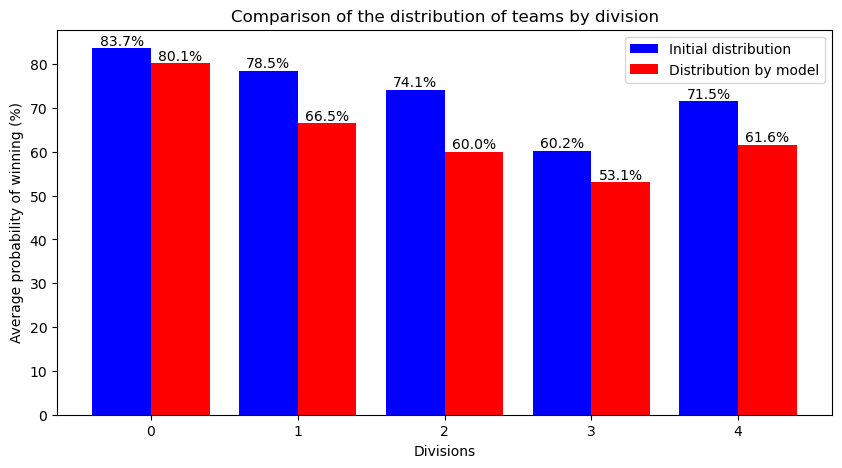

In [5]:
rank_and_evaluate_teams(season, new_model, num_divisions=5, min_teams_per_division=4)